In [40]:
import practicalSPARQL
import pandas as pd
import ast
import matplotlib.pyplot as plt

In [41]:
root_q = 'queries'
root_d = 'results'

# read login data
login = pd.read_json('config_sparql.json')
ENDPOINT = login['endpoint'][0]
USERNAME = login['username'][0]
PASSWORD = login['password'][0]

# create sparql object
sparql = practicalSPARQL.practicalWrapper(ENDPOINT)
sparql.setCredentials(USERNAME, PASSWORD)

print("--- Querying ENDPOINT: {} ---".format(ENDPOINT))

--- Querying ENDPOINT: http://devmeta.sphaera.mpiwg-berlin.mpg.de/sparql ---


In [42]:
q = practicalSPARQL.stringify_SPARQL('elements_query_050824.sparql')    # select data from the ttl file as a dataframe
df = sparql.select_as_dataframe(q)

In [43]:
q = practicalSPARQL.stringify_SPARQL('books_query.sparql')    # select data from the ttl file as a dataframe
books = sparql.select_as_dataframe(q)

In [44]:
excel_file_path = 'C:\\Users\\nogas\\Image_data\\celestial_circles.xlsx'
excel_data = pd.read_excel(excel_file_path)
df_1 = pd.merge(df, excel_data, on='cluster_name', how='left')

In [45]:
excel_file_path = 'C:\\Users\\nogas\\Image_data\\celestial_circles_geometrical_subjects.xlsx'
excel_data = pd.read_excel(excel_file_path)
df_2 = pd.merge(df_1, excel_data, on='cluster_name', how='left')

In [46]:
excel_file_path = 'C:\\Users\\nogas\\Image_data\\corrected_celestial_circles.xlsx'
excel_data = pd.read_excel(excel_file_path_1)
df_full = pd.merge(df_2, excel_data, on='cluster_name', how='left')

In [49]:
# Print column names of df_full
print("Column names in df_full:")
print(df_full.columns.tolist())


Column names in df_full:
['images', 'cluster_name', 'cks', 'book', 'bid', 'part_or_adaption', 'part_or_adaption_label', 'type_label', 'custom_identifier', 'place', 'year', 'flag', '3D_x', 'human figures_x', 'material object (double lines)', 'multiple moments', 'multiple perspectives', 'color', 'multiple circles', 'decorated or stars, tail, scales', 'picture', 'terraqueous globe', 'diagram_x', 'small circles representing mutual three dimensional motion', 'symbol', '3D_y', 'human figures_y', 'material representation', 'diagram_y', '3D decoration', '3D main point', 'Unnamed: 3']


C:\Users\nogas\AppData\Local\Temp\ipykernel_15656\1537278119.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_horizon['year'] = filtered_df_horizon['year'].astype(int)
C:\Users\nogas\AppData\Local\Temp\ipykernel_15656\1537278119.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_horizon['interval'] = pd.cut(filtered_df_horizon['year'], bins=bins, labels=labels, right=False)
C:\Users\nogas\AppData\Local\Temp\ipykernel_15656\1537278119.py:35: FutureWarning: The default of observed

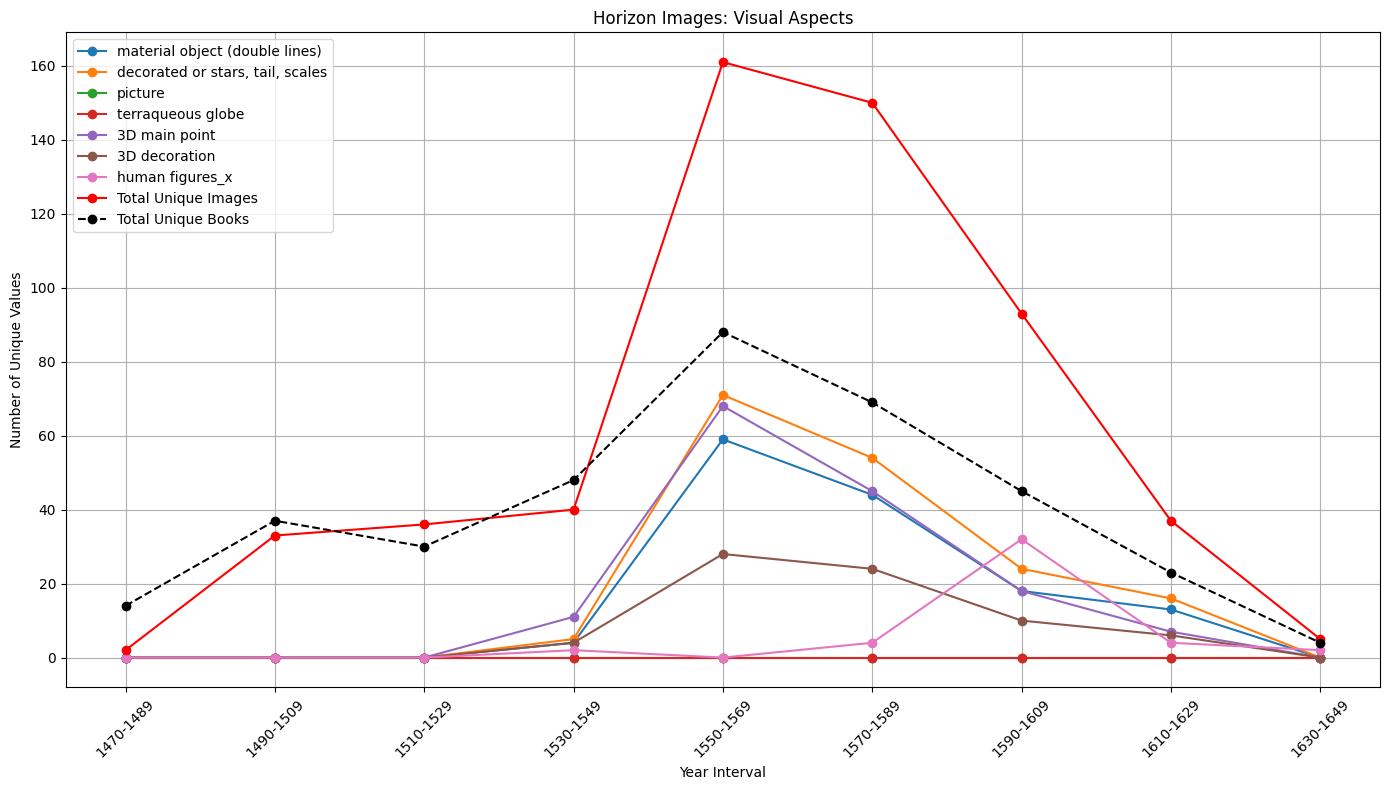

In [51]:
# Step 1: Filter df_full for images containing CK_Horizon
filtered_df_horizon = df_full[df_full['cks'].str.contains('CK_Horizon', na=False)]

# Ensure the year column is of integer type
filtered_df_horizon['year'] = filtered_df_horizon['year'].astype(int)

# Step 2: Define the columns to analyze
columns_to_analyze = [
    'material object (double lines)',
    'decorated or stars, tail, scales',
    'picture',
    'terraqueous globe',
    '3D main point',
    '3D decoration',
    'human figures_x',
]

# Step 3: Create bins and labels for twenty-year intervals
bins = [1470, 1490, 1510, 1530, 1550, 1570, 1590, 1610, 1630, 1650]
labels = ['1470-1489', '1490-1509', '1510-1529', '1530-1549', 
          '1550-1569', '1570-1589', '1590-1609', '1610-1629', '1630-1649']

# Step 4: Create intervals in the filtered_df_horizon
if 'year' in filtered_df_horizon.columns:
    filtered_df_horizon['interval'] = pd.cut(filtered_df_horizon['year'], bins=bins, labels=labels, right=False)

# Step 5: Create intervals in the books DataFrame
if 'year' in books.columns:
    books['year'] = books['year'].astype(int)  # Ensure books year is also an integer
    books['interval'] = pd.cut(books['year'], bins=bins, labels=labels, right=False)

# Function to count unique images by column
def count_unique_images_by_column(column_name, value):
    filtered_count = filtered_df_horizon[filtered_df_horizon[column_name] == value]
    return filtered_count.groupby('interval')['images'].nunique().reindex(labels, fill_value=0)

# Step 6: Collect data for the specified columns
data_to_plot = {}
for column in columns_to_analyze:
    data_to_plot[column] = count_unique_images_by_column(column, 'yes')

# Step 7: Calculate total unique images in the filtered DataFrame
total_unique_images = filtered_df_horizon.groupby('interval')['images'].nunique().reindex(labels, fill_value=0)

# Step 8: Calculate total unique books from the books DataFrame
total_unique_books = books.groupby('interval')['book'].nunique().reindex(labels, fill_value=0)

# Step 9: Combine the data into a DataFrame
side_by_side_data = pd.DataFrame(data_to_plot)
side_by_side_data['Total Unique Images'] = total_unique_images
side_by_side_data['Total Unique Books'] = total_unique_books

# Step 10: Plotting
fig, ax = plt.subplots(figsize=(14, 8))

# Step 11: Plot lines for each category
for column in side_by_side_data.columns:
    if column == 'Total Unique Books':
        ax.plot(labels, side_by_side_data[column], marker='o', linestyle='--', color='black', label=column)  # Broken black line
    elif column == 'Total Unique Images':
        ax.plot(labels, side_by_side_data[column], marker='o', linestyle='-', color='red', label=column)  # Solid red line
    else:
        ax.plot(labels, side_by_side_data[column], marker='o', linestyle='-', label=column)

# Step 12: Formatting the plot
ax.set_xlabel('Year Interval')
ax.set_ylabel('Number of Unique Values')
ax.set_title('Horizon Images: Visual Aspects')
ax.legend(loc='upper left')
ax.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

C:\Users\nogas\AppData\Local\Temp\ipykernel_15656\1854377640.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_meridian['year'] = filtered_df_meridian['year'].astype(int)
C:\Users\nogas\AppData\Local\Temp\ipykernel_15656\1854377640.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_meridian['interval'] = pd.cut(filtered_df_meridian['year'], bins=bins, labels=labels, right=False)
C:\Users\nogas\AppData\Local\Temp\ipykernel_15656\1854377640.py:35: FutureWarning: The default of obse

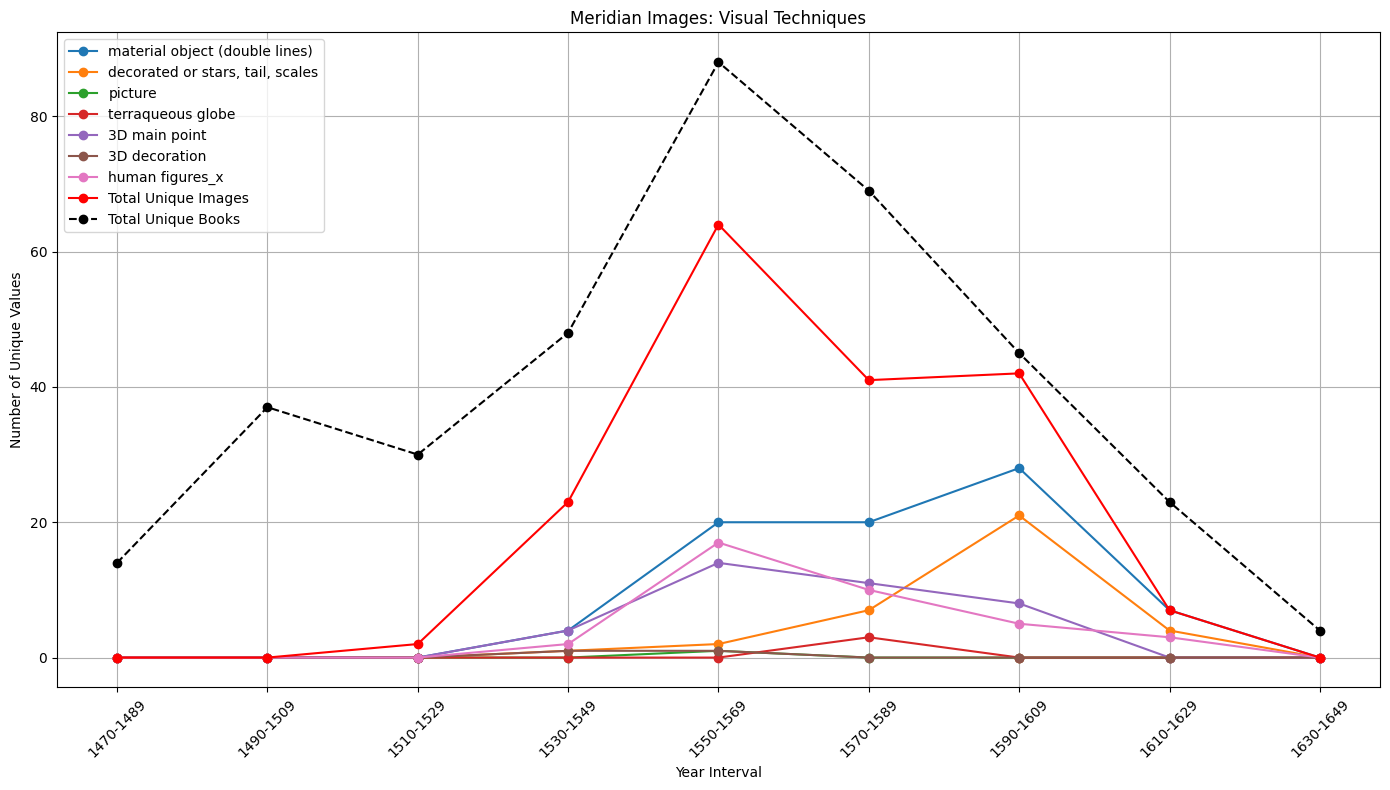

In [60]:

# Step 1: Filter df_full for images containing CK_Meridian
filtered_df_meridian = df_full[df_full['cks'].str.contains('CK_Meridian', na=False)]

# Ensure the year column is of integer type
filtered_df_meridian['year'] = filtered_df_meridian['year'].astype(int)

# Step 2: Define the columns to analyze
columns_to_analyze = [
    'material object (double lines)',
    'decorated or stars, tail, scales',
    'picture',
    'terraqueous globe',
    '3D main point',
    '3D decoration',
    'human figures_x'
]

# Step 3: Create bins and labels for twenty-year intervals
bins = [1470, 1490, 1510, 1530, 1550, 1570, 1590, 1610, 1630, 1650]
labels = ['1470-1489', '1490-1509', '1510-1529', '1530-1549', 
          '1550-1569', '1570-1589', '1590-1609', '1610-1629', '1630-1649']

# Step 4: Create intervals in the filtered_df_meridian
if 'year' in filtered_df_meridian.columns:
    filtered_df_meridian['interval'] = pd.cut(filtered_df_meridian['year'], bins=bins, labels=labels, right=False)

# Step 5: Create intervals in the books DataFrame
if 'year' in books.columns:
    books['year'] = books['year'].astype(int)  # Ensure books year is also an integer
    books['interval'] = pd.cut(books['year'], bins=bins, labels=labels, right=False)

# Function to count unique images by column
def count_unique_images_by_column(column_name, value):
    filtered_count = filtered_df_meridian[filtered_df_meridian[column_name] == value]
    return filtered_count.groupby('interval')['images'].nunique().reindex(labels, fill_value=0)

# Step 6: Collect data for the specified columns
data_to_plot = {}
for column in columns_to_analyze:
    data_to_plot[column] = count_unique_images_by_column(column, 'yes')

# Step 7: Calculate total unique images in the filtered DataFrame
total_unique_images = filtered_df_meridian.groupby('interval')['images'].nunique().reindex(labels, fill_value=0)

# Step 8: Calculate total unique books from the books DataFrame
total_unique_books = books.groupby('interval')['book'].nunique().reindex(labels, fill_value=0)

# Step 9: Combine the data into a DataFrame
side_by_side_data = pd.DataFrame(data_to_plot)
side_by_side_data['Total Unique Images'] = total_unique_images
side_by_side_data['Total Unique Books'] = total_unique_books

# Step 10: Plotting
fig, ax = plt.subplots(figsize=(14, 8))

# Step 11: Plot lines for each category
for column in side_by_side_data.columns:
    if column == 'Total Unique Books':
        ax.plot(labels, side_by_side_data[column], marker='o', linestyle='--', color='black', label=column)  # Broken black line
    elif column == 'Total Unique Images':
        ax.plot(labels, side_by_side_data[column], marker='o', linestyle='-', color='red', label=column)  # Solid red line
    else:
        ax.plot(labels, side_by_side_data[column], marker='o', linestyle='-', label=column)

# Step 12: Formatting the plot
ax.set_xlabel('Year Interval')
ax.set_ylabel('Number of Unique Values')
ax.set_title('Meridian Images: Visual Techniques')
ax.legend(loc='upper left')
ax.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

In [53]:
# Print column names of df_full
print("Column names in df_full:")
print(df_full.columns.tolist())


Column names in df_full:
['images', 'cluster_name', 'cks', 'book', 'bid', 'part_or_adaption', 'part_or_adaption_label', 'type_label', 'custom_identifier', 'place', 'year', 'flag', '3D_x', 'human figures_x', 'material object (double lines)', 'multiple moments', 'multiple perspectives', 'color', 'multiple circles', 'decorated or stars, tail, scales', 'picture', 'terraqueous globe', 'diagram_x', 'small circles representing mutual three dimensional motion', 'symbol', '3D_y', 'human figures_y', 'material representation', 'diagram_y', '3D decoration', '3D main point', 'Unnamed: 3']


C:\Users\nogas\AppData\Local\Temp\ipykernel_15656\2998332044.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_elevation['year'] = filtered_df_elevation['year'].astype(int)
C:\Users\nogas\AppData\Local\Temp\ipykernel_15656\2998332044.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_elevation['interval'] = pd.cut(filtered_df_elevation['year'], bins=bins, labels=labels, right=False)
C:\Users\nogas\AppData\Local\Temp\ipykernel_15656\2998332044.py:31: FutureWarning: The default of 

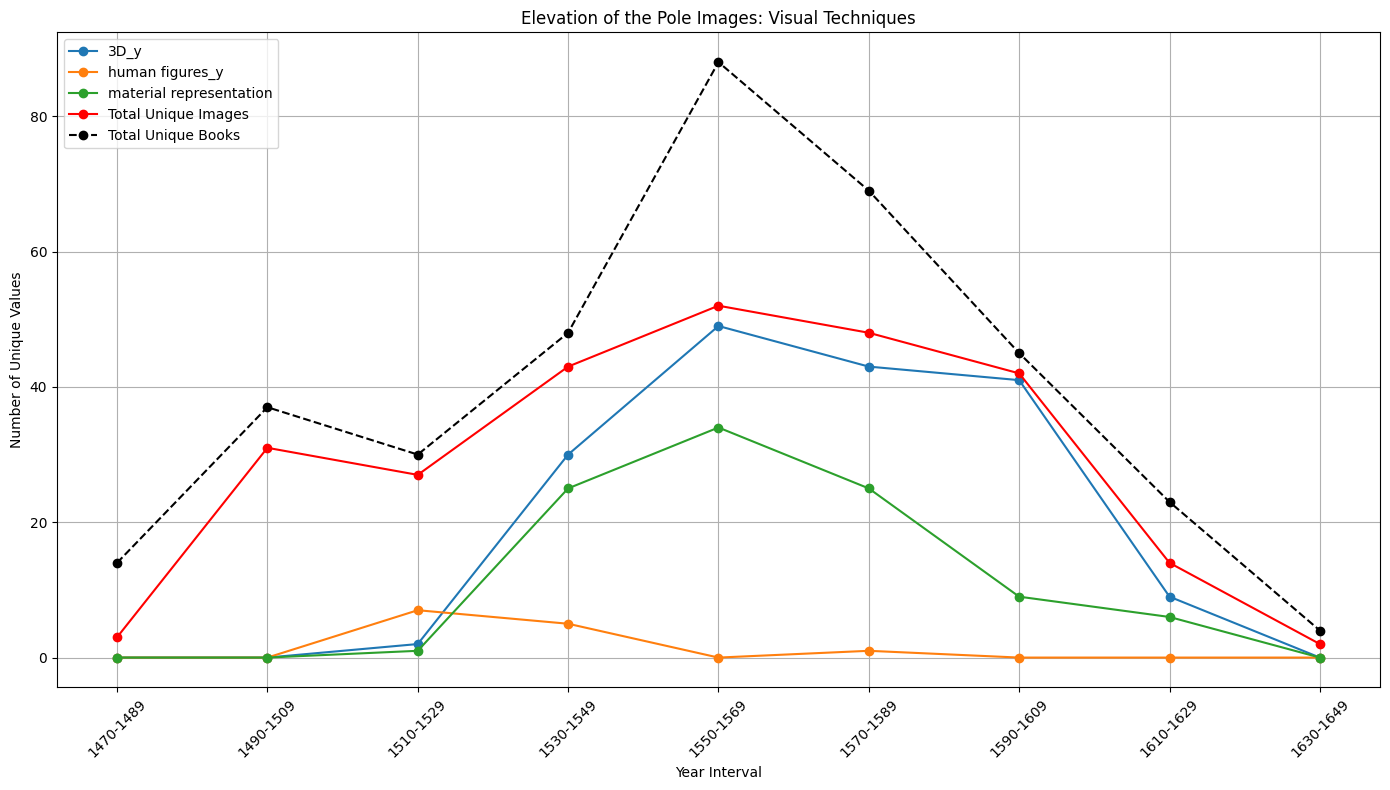

In [59]:
# Step 1: Filter df_full for images containing CK_Elevation of the Pole
filtered_df_elevation = df_full[df_full['cks'].str.contains('CK_Elevation of the Pole', na=False)]

# Ensure the year column is of integer type
filtered_df_elevation['year'] = filtered_df_elevation['year'].astype(int)

# Step 2: Define the columns to analyze
columns_to_analyze = [   
    '3D_y',
    'human figures_y',
    'material representation'  
]

# Step 3: Create bins and labels for twenty-year intervals
bins = [1470, 1490, 1510, 1530, 1550, 1570, 1590, 1610, 1630, 1650]
labels = ['1470-1489', '1490-1509', '1510-1529', '1530-1549', 
          '1550-1569', '1570-1589', '1590-1609', '1610-1629', '1630-1649']

# Step 4: Create intervals in the filtered_df_elevation
if 'year' in filtered_df_elevation.columns:
    filtered_df_elevation['interval'] = pd.cut(filtered_df_elevation['year'], bins=bins, labels=labels, right=False)

# Step 5: Create intervals in the books DataFrame
if 'year' in books.columns:
    books['year'] = books['year'].astype(int)  # Ensure books year is also an integer
    books['interval'] = pd.cut(books['year'], bins=bins, labels=labels, right=False)

# Function to count unique images by column
def count_unique_images_by_column(column_name, value):
    filtered_count = filtered_df_elevation[filtered_df_elevation[column_name] == value]
    return filtered_count.groupby('interval')['images'].nunique().reindex(labels, fill_value=0)

# Step 6: Collect data for the specified columns
data_to_plot = {}
for column in columns_to_analyze:
    data_to_plot[column] = count_unique_images_by_column(column, 'yes')

# Step 7: Calculate total unique images in the filtered DataFrame
total_unique_images = filtered_df_elevation.groupby('interval')['images'].nunique().reindex(labels, fill_value=0)

# Step 8: Calculate total unique books from the books DataFrame
total_unique_books = books.groupby('interval')['book'].nunique().reindex(labels, fill_value=0)

# Step 9: Combine the data into a DataFrame
side_by_side_data = pd.DataFrame(data_to_plot)
side_by_side_data['Total Unique Images'] = total_unique_images
side_by_side_data['Total Unique Books'] = total_unique_books

# Step 10: Plotting
fig, ax = plt.subplots(figsize=(14, 8))

# Step 11: Plot lines for each category
for column in side_by_side_data.columns:
    if column == 'Total Unique Books':
        ax.plot(labels, side_by_side_data[column], marker='o', linestyle='--', color='black', label=column)  # Broken black line
    elif column == 'Total Unique Images':
        ax.plot(labels, side_by_side_data[column], marker='o', linestyle='-', color='red', label=column)  # Solid red line
    else:
        ax.plot(labels, side_by_side_data[column], marker='o', linestyle='-', label=column)

# Step 12: Formatting the plot
ax.set_xlabel('Year Interval')
ax.set_ylabel('Number of Unique Values')
ax.set_title('Elevation of the Pole Images: Visual Techniques')
ax.legend(loc='upper left')
ax.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()